In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from base.logging import Logger

In [4]:
PROJECT = 'covid'
ENV = 'dev'
ID = f'{PROJECT}-{ENV}'

global log
log = Logger(ID)

In [5]:
from base.data import Data

In [6]:
data = Data()
data.extract()
data.transform()
data.load()

/Users/tjordan/Documents/github/covid19/base/data.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df.index = pd.to_datetime(self.df.index)


In [15]:
class Forecast:
    def __init__(self,df):
        self.log = log
        self.df = df
        
        self.periods_fc = 90
        self.main_strt_dt = datetime.datetime(2022,7,1)
        self.test_strt_dt = (self.main_strt_dt - datetime.timedelta(days=self.periods_fc))
        
        self.test_model = None
        self.main_model = None
        
        self.test_fc = None
        self.main_fc = None
        
        self.lockdowns = pd.DataFrame([
            {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
            {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
            {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
            {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
        ])
        for t_col in ['ds', 'ds_upper']:
            self.lockdowns[t_col] = pd.to_datetime(self.lockdowns[t_col])
        self.lockdowns['upper_window'] = (self.lockdowns['ds_upper'] - self.lockdowns['ds']).dt.days
    
    def run(self,run_type):        
        if run_type == 'test':
            train_df = self.df.loc[self.df.ds<=self.test_strt_dt]
        elif run_type == 'main':
            train_df = self.df.loc[self.df.ds<=self.main_strt_dt]
        
        model = Prophet(
            growth='linear',
            changepoints=None,
            n_changepoints=25,
            changepoint_range=0.8,
            yearly_seasonality='auto',
            weekly_seasonality='auto',
            seasonality_mode='additive',
            # holidays=self.lockdowns,
            # seasonality_prior_scale=10.0,
            # holidays_prior_scale=10.0,
            # changepoint_prior_scale=0.01,
            # mcmc_samples=0,
            # interval_width=0.80,
            # uncertainty_samples=1000,
            # stan_backend=None,
        )
        model.fit(train_df)
        future = model.make_future_dataframe(periods=self.periods_fc,include_history=False)
        setattr(self,f'{run_type}_fc',model.predict(future))
        setattr(self,f'{run_type}_model',model)
    
    def compile(self):
        self.fc = pd.concat([
            self.df.loc[self.df.ds<=self.test_strt_dt],
            self.test_fc.merge(self.df,how='inner',on='ds'),
            self.main_fc
        ],axis=0)
    
    def graph(self):
        plt.style.use('fivethirtyeight') # ggplot, fivethirtyeight, tableau-colorblind10, grayscale

        fig, ax1 = plt.subplots(figsize=(12,6))
        fig.suptitle('Covid19 Time Series Forecast - Richmond, VA', fontsize=18) # fontweight='bold'
        fig.tight_layout()
        ax1.grid(True)

        ax1.plot(self.fc.ds,self.fc.y,color='#091d63',label='Y',linewidth=2)
        ax1.plot(self.fc.ds,self.fc.yhat,color='#630909',linestyle='--',label='Yhat',linewidth=2)
        ax1.plot(self.fc.ds,self.fc.yhat_lower,color='#000000',linestyle=':',label='Yhat Lower',linewidth=2)
        ax1.plot(self.fc.ds,self.fc.yhat_upper,color='#000000',linestyle=':',label='Yhat Upper',linewidth=2)
        ax1.set_xlabel('Date',fontsize=10)
        ax1.set_ylabel('Covid19 Cases',fontsize=10)
        ax1.legend(loc='upper left')
        
        ax1.xaxis.set_tick_params(rotation=45)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.figtext(0,-0.2,f'Data up to {self.main_strt_dt.strftime("%Y-%m-%d")}',fontsize=10)
        
        self.main_model.plot_components(self.main_fc);

In [16]:
fc = Forecast(data.df)

In [17]:
fc.run('test')
fc.run('main')
fc.compile()

18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:14 - cmdstanpy - INFO - Chain [1] done processing


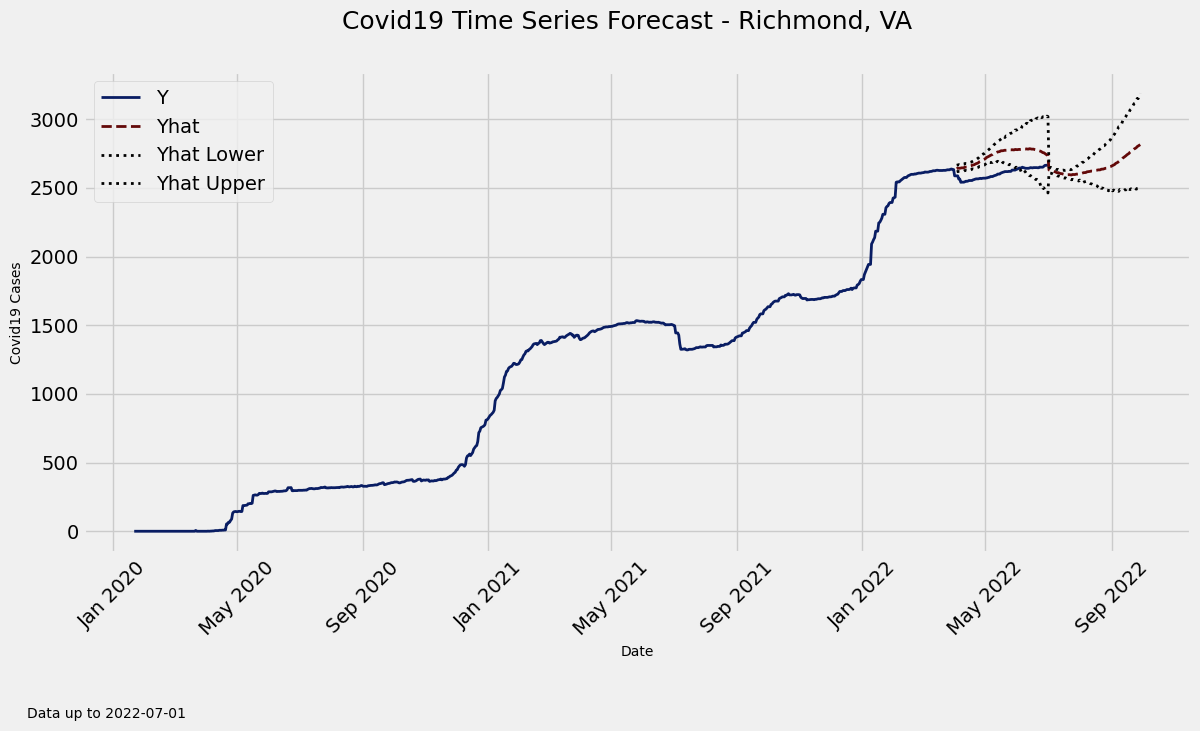

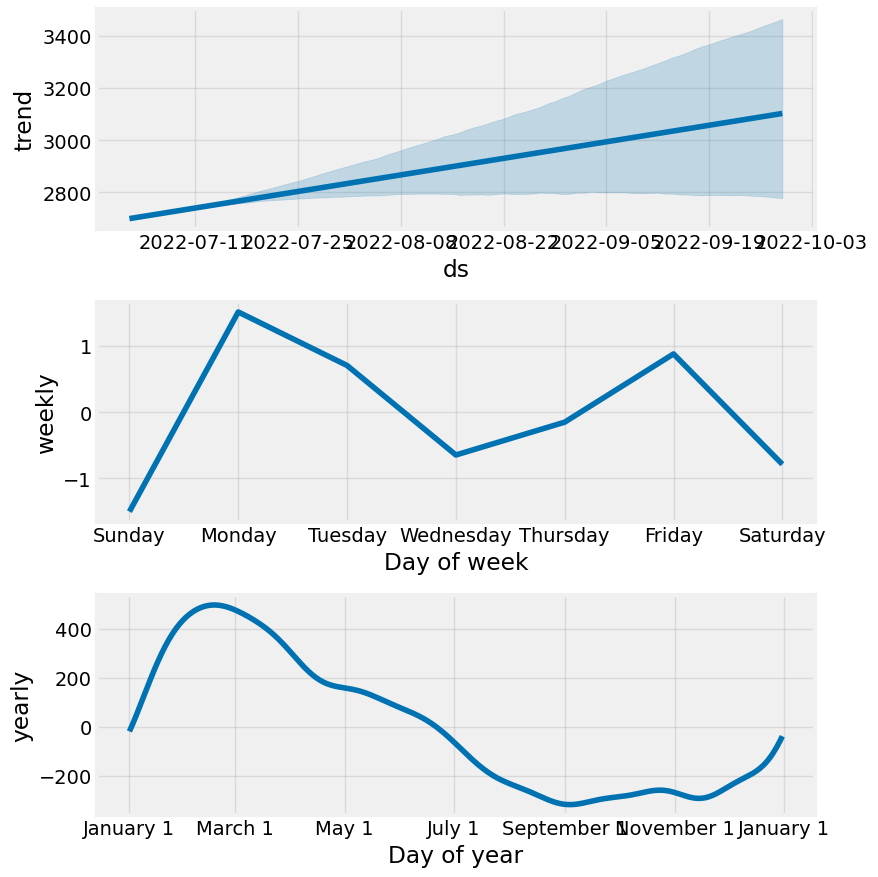

In [18]:
fc.graph()